<a href="https://colab.research.google.com/github/ketki000/COVID---Detector-CNN---Inception-/blob/main/Covid_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import shutil

# Deep learning
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Conv3D, MaxPooling3D,GlobalAveragePooling3D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam,SGD, RMSprop
import tensorflow as tf 
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

from PIL import Image
from skimage import io
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = '/content/drive/MyDrive/RRCAT Internship/COVID_dataset/COVID-19_Radiography_Dataset/'
# PATH = '/content/drive/MyDrive/COVID_dataset/COVID-19_Radiography_Dataset/'


train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH,'test')

BATCH_SIZE = 32
IMG_SIZE = (299, 299)

In [4]:
print(train_dir)
print(validation_dir)
print(test_dir)

/content/drive/MyDrive/RRCAT Internship/COVID_dataset/COVID-19_Radiography_Dataset/train
/content/drive/MyDrive/RRCAT Internship/COVID_dataset/COVID-19_Radiography_Dataset/validation
/content/drive/MyDrive/RRCAT Internship/COVID_dataset/COVID-19_Radiography_Dataset/test


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

#loading train dataset: from images in a directory to tensorflow dataset
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             labels='inferred',                  #class names = subdirectory names 
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 14839 files belonging to 2 classes.


In [7]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
train_images = 14839
valid_images = 3267
test_images = 3089
BATCH_SIZE = 32

In [9]:
len(train_dataset)   # 14839/32 batches

464

In [10]:
#loading validation dataset:  from images in a directory to tensorflow dataset
validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             labels='inferred',   #class names = subdirectory names 
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3267 files belonging to 2 classes.


In [11]:
len(validation_dataset)  # 3267/32 batches

103

In [12]:
#loading test dataset:  from images in a directory to tensorflow dataset
test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             labels='inferred',   #class names = subdirectory names 
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3089 files belonging to 2 classes.


In [13]:

class_names = train_dataset.class_names
class_names

['disease', 'normal']

In [14]:
train_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

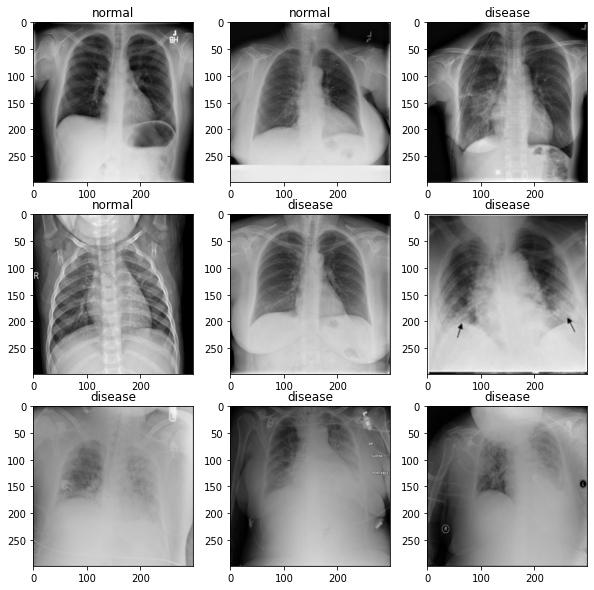

In [15]:
#Visualize training dataset
#matplotlib
plt.figure(figsize=(10, 10))      #dimension of plot
for images, labels in train_dataset.take(1):    #dataset.take(1) returns a tuple (data, label)
  for i in range(9):               #range(num)  num>=1 && num <= nrows * ncols 
    ax = plt.subplot(3, 3, i+1)    #subplot(nrows, ncols, index >=1 && <= (nrows*ncols), **kwargs)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

In [16]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=103>

In [17]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 103
Number of test batches: 97


In [18]:
#Using ImageDataGenerator for training and validation data

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
# Create Image Data Generator for Train'& validation Set
#performing data augmentation
image_gen = ImageDataGenerator(
                                  #rescale = 1./255, ??
                                  zoom_range = 0.2,
                                  height_shift_range=0.1,
                                  width_shift_range=0.1,
                               rotation_range = 5,
                                shear_range=10.0,
                                #zoom_range=[0.5, 1.5],
                                preprocessing_function=preprocess_input         
                               )
# Create Image Data Generator for Validation Set
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input )

In [19]:
train_generator = image_gen.flow_from_directory(
      train_dir,
      target_size=IMG_SIZE,
      class_mode='binary',
      batch_size=BATCH_SIZE,
      )

Found 14839 images belonging to 2 classes.


In [20]:
valid_generator = test_data_gen.flow_from_directory(
      validation_dir,
      target_size=IMG_SIZE,
      class_mode='binary', 
      batch_size=BATCH_SIZE,
      )

Found 3267 images belonging to 2 classes.


In [21]:
train_generator.class_indices

{'disease': 0, 'normal': 1}

In [23]:
x,y = next(train_generator)


In [24]:
print("x ", type(x))
print("y ", type(y))
print("x ", x.shape)
print("y ", y.shape)

x  <class 'numpy.ndarray'>
y  <class 'numpy.ndarray'>
x  (32, 299, 299, 3)
y  (32,)


In [25]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

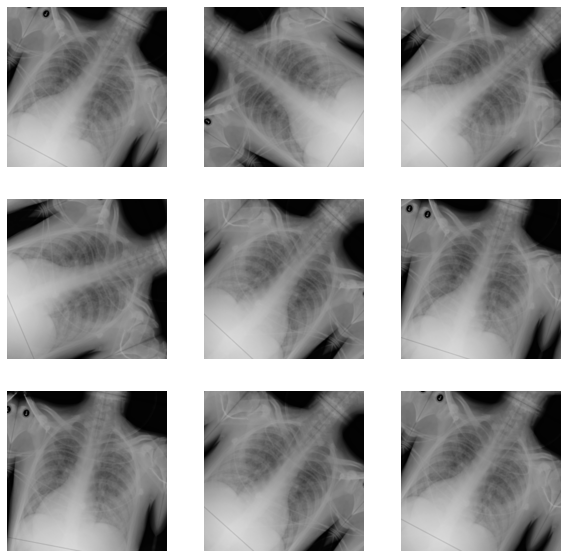

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

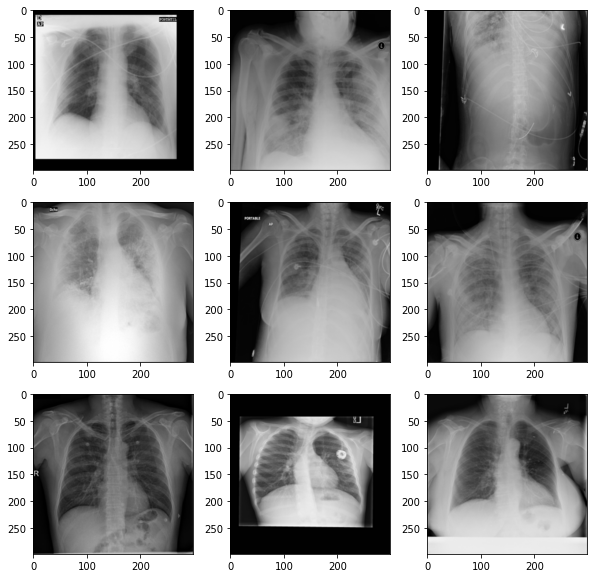

In [27]:
#Visualize training dataset
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # plt.imshow(augmented_image[0] / 255)
    plt.imshow(image[i].numpy().astype("uint8"))

In [28]:
#Use buffered prefetching to load images from disk without having I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [29]:
#Use AUTOTUNING functions for optimization of hardware and performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BATCH_SIZE, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.repeat(5) # num epochs

In [30]:
import pandas as pd
from matplotlib.pyplot import imread
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import keras 

In [31]:
num_classes=2
IMG_SHAPE = IMG_SIZE + (3,)

In [34]:
# create the base pre-trained model
#
base_model = InceptionV3(input_shape=IMG_SHAPE,weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


In [35]:
IMG_SHAPE

(299, 299, 3)

In [36]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [37]:
# let's add a fully-connected layer
x = Dense(4096, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(1, activation='sigmoid')(x)

In [38]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [39]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [40]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [41]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='BinaryCrossentropy', metrics=['accuracy'])

In [42]:
valid_images//BATCH_SIZE

102

In [43]:
train_images//BATCH_SIZE

463

In [45]:
len(train_generator) // train_generator.batch_size

14

In [46]:
len(valid_generator) // valid_generator.batch_size

3

In [44]:
model.fit(
    # train_generator,
    # steps_per_epoch=463,         #train_images//BATCH_SIZE
    # epochs=5,
    # validation_data=valid_generator,
    # validation_steps=  102,       #valid_images//BATCH_SIZE
    #  verbose=1    

    train_generator,
    steps_per_epoch = len(train_generator) // train_generator.batch_size,
    validation_data = valid_generator,
    validation_steps=len(valid_generator) // valid_generator.batch_size,
    epochs = 10 
    )

Epoch 1/10
14/14 [==============================] - 102s 6s/step - loss: 6.5716 - accuracy: 0.5022 - val_loss: 1.6154 - val_accuracy: 0.5104
Epoch 2/10
14/14 [==============================] - 84s 6s/step - loss: 1.1416 - accuracy: 0.6228 - val_loss: 0.6382 - val_accuracy: 0.7396
Epoch 3/10
14/14 [==============================] - 80s 6s/step - loss: 1.2744 - accuracy: 0.6116 - val_loss: 0.7424 - val_accuracy: 0.6354
Epoch 4/10
14/14 [==============================] - 74s 5s/step - loss: 0.8916 - accuracy: 0.6741 - val_loss: 0.6181 - val_accuracy: 0.7396
Epoch 5/10
14/14 [==============================] - 77s 6s/step - loss: 0.7350 - accuracy: 0.7232 - val_loss: 0.4041 - val_accuracy: 0.7604
Epoch 6/10
14/14 [==============================] - 75s 6s/step - loss: 0.7275 - accuracy: 0.6607 - val_loss: 0.3681 - val_accuracy: 0.8229
Epoch 7/10
14/14 [==============================] - 71s 5s/step - loss: 0.6529 - accuracy: 0.7031 - val_loss: 0.5391 - val_accuracy: 0.7083
Epoch 8/10
14/14 [=

In [47]:
# direct evaluating test dataset without IDG 
initial_epochs = 10
#loss, accuracy = model.evaluate(test_dataset)

test_score = model.evaluate(preprocess_input(test_dataset))

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 

print("[INFO] Loss: ",test_score[0])

TypeError: ignored

In [48]:
target_names = []

for key in train_generator.class_indices:

    target_names.append(key)

print(target_names)

['disease', 'normal']


In [53]:
Y_pred = model.predict(valid_generator, valid_images // BATCH_SIZE+1)


In [50]:
from sklearn.metrics import confusion_matrix

In [54]:
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))


Confusion Matrix
[[1701    0]
 [1566    0]]


In [56]:
from sklearn.metrics import classification_report

In [57]:
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     disease       0.52      1.00      0.68      1701
      normal       0.00      0.00      0.00      1566

    accuracy                           0.52      3267
   macro avg       0.26      0.50      0.34      3267
weighted avg       0.27      0.52      0.36      3267



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
